In [186]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import pandas
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [122]:
def img_norm(img):
    ratio = 255/(img.max()-img.min())
    new_img = (img*ratio).astype(np.uint8)
    #new_max = new_img.max()
    return new_img

In [135]:
gt_path = '../violation_data/test/gp_violations_seg.h5'
pred_mvms_path = './MVMS_CityStreet/counting_results/counting_num_07192138.h5'
pred_mvms_unet_path = './MVMS_UNet_CityStreet/counting_results/counting_num_07261737.h5'
pred_unet_path = './MVMS_UNet_Only_CityStreet/counting_results/counting_num_07291728.h5'
pred_msunet_path = './MVMS_UNet_Only_CityStreet/counting_results/counting_num_07291735.h5'

In [136]:
gt = h5py.File(gt_path,'r')
pred_mvms = h5py.File(pred_mvms_path,'r')
pred_mvms_unet = h5py.File(pred_mvms_unet_path,'r')
pred_unet = h5py.File(pred_unet_path,'r')
pred_msunet = h5py.File(pred_msunet_path,'r')

In [137]:
print(gt.keys())
print(pred_mvms.keys())
print(pred_mvms_unet.keys())
print(pred_unet.keys())
print(pred_msunet.keys())

<KeysViewHDF5 ['count', 'density_maps', 'segment_maps']>
<KeysViewHDF5 ['count1_GProi', 'count2_GProi', 'count3_GProi', 'count_gplane', 'mae_GP', 'mae_view1', 'mae_view1_GP', 'mae_view1_GProi', 'mae_view2', 'mae_view2_GP', 'mae_view2_GProi', 'mae_view3', 'mae_view3_GP', 'mae_view3_GProi', 'pred_dmap_gplane']>
<KeysViewHDF5 ['pred_dmap_gplane']>
<KeysViewHDF5 ['pred_dmap_gplane']>
<KeysViewHDF5 ['pred_dmap_gplane']>


In [138]:
gt = gt['segment_maps']
mvms = pred_mvms['pred_dmap_gplane']
mvms_unet = pred_mvms_unet['pred_dmap_gplane']
unet = pred_unet['pred_dmap_gplane']
msunet = pred_msunet['pred_dmap_gplane']

In [139]:
gt = np.array(gt).squeeze()
mvms = np.array(mvms).squeeze()
mvms_unet = np.array(mvms_unet).squeeze()
unet = np.array(unet).squeeze()
msunet = np.array(msunet).squeeze()

In [140]:
print(gt[0].max(), gt[0].min())
print(unet.max(),unet.min())

1 0
0.9999995 0.00013441758


In [141]:
mvms_new = []
for img in mvms:
    img = cv2.resize(img,(640,768))
    img = img_norm(img)
    img[img<35] =1
    img[img>=35] = 0
    mvms_new.append(img)

In [142]:
mvms = np.array(mvms_new)

In [143]:
print(mvms[0])

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


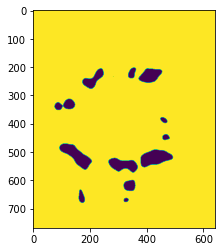

In [144]:
plt.imshow(mvms[0])

In [145]:
mvms_unet_new = []
for img in mvms_unet:
    img[img<0.5]=0
    img[img>0.5]=1
    mvms_unet_new.append(img)
    
mvms_unet = np.array(mvms_unet_new)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


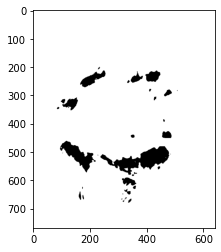

In [146]:
print(mvms_unet[0])
plt.imshow(mvms_unet[0].squeeze(),cmap='gray')

In [147]:
print(mvms[0,0,0]==mvms_unet[0,0,0])

True


In [148]:
unet_new = []
for img in unet:
    img[img<0.5]=0
    img[img>0.5]=1
    unet_new.append(img)
    
unet = np.array(unet_new)

In [149]:
msunet_new = []
for img in msunet:
    img[img<0.5]=0
    img[img>0.5]=1
    msunet_new.append(img)
    
msunet = np.array(msunet_new)

In [150]:
print(msunet.shape)

(200, 768, 640)


In [174]:
def pixel_acc(gt,pred):
    acc = 0
    recall =0
    precision =0
    f1 = 0
    for i in tqdm(range(gt.shape[0])):
        gt_i = gt[i].flatten().squeeze()
        #print(gt_i)
        pred_i = pred[i].flatten().squeeze()
        [[tp,fn],[fp,tn]] = confusion_matrix(gt_i,pred_i)
        acc_i = (tp+tn)/(tp+fn+fp+tn)
        recall_i = tp/(tp+fn)
        precision_i = tp/(tp+fp)
        f1_i = 2*precision_i*recall_i/(precision_i+recall_i)
        
        acc += acc_i
        recall += recall_i
        precision += precision_i
        f1 += f1_i

    acc = acc/len(gt)
    recall = recall/len(gt)
    precision = precision /len(gt)
    f1 = f1/len(gt)
    return acc,recall,precision,f1


In [177]:
acc,recall,precision,f1 = pixel_acc(gt,mvms)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.80it/s]


In [178]:
print(acc,recall,precision,f1)

0.9613593444824222 0.5498640244155293 0.6935691479067639 0.6051788350291889


In [179]:
acc,recall,precision,f1 = pixel_acc(gt,mvms_unet)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:55<00:00,  1.14it/s]


In [180]:
print(acc,recall,precision,f1)

0.9602390238444011 0.5625729894506474 0.6605925259226634 0.5992470394234416


In [175]:
acc,recall,precision,f1 = pixel_acc(gt,unet)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


In [176]:
print(acc,recall,precision,f1)

0.9608267008463539 0.563018802777009 0.6682100038615679 0.6030940796291762


In [181]:
msunet = np.array(msunet,'b')

In [182]:
gt = np.array(gt,'b')

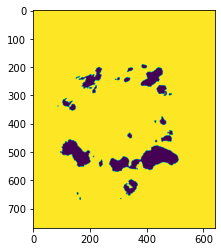

In [183]:
plt.imshow(msunet[0])

In [184]:
acc,recall,precision,f1 = pixel_acc(gt,msunet)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.41it/s]


In [185]:
print(acc,recall,precision,f1)

0.9600034688313801 0.5899907710144401 0.646036973294946 0.6098109315273382


In [188]:
import camera_proj_Zhang as proj

In [192]:
test = proj.World2Image('view1',gt[0,0],gt[0,1],gt[0,2])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [191]:
print(test)

[array([327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 327764.95261033, 327764.95261033, 327764.95261033,
       327764.95261033, 